# _1. Contexto

Os dados que vão ser trabalhados são as **contagens das passagens de bicicletas** numa localização em Lisboa e que são disponibilizados em [EMEL Open Data](https://opendata.emel.pt/) como dados abertos (a título de curiosidade, refira-se que, entre 2 e 8 de março de 2024, comemorou-se o(s) [***Open Data Day(s)***](https://opendataday.org/)).

Estes dados são recolhidos por equipamentos chamados **contadores automáticos**, que, no caso de Lisboa, são equipamentos da empresa [Fernando L. Gaspar, S.A.](https://gaspar.com.pt/), como os exibidos [aqui](https://gaspar.com.pt/my-product/contagem-de-velocipedes-em-lisboa/).

# _2. Importação de bibliotecas do Python

In [1]:
import requests
import json
import pandas as pd
import folium
from datetime import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL

# _3. Análise da localizações dos contadores para escolha de uma localização

`/cycling/bicyclecounter/locations` > Get list locations (detectors in the network)

In [2]:
URL = 'https://opendata.emel.pt/cycling/bicyclecounter/locations'
response_api = requests.get(URL)
#print(response_api.status_code)

data_loc = json.loads(response_api.text)
df_loc = pd.json_normalize(data_loc)
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   locationId         31 non-null     object
 1   tenantIdentifier   31 non-null     object
 2   name               31 non-null     object
 3   cp7                31 non-null     object
 4   freguesia          31 non-null     object
 5   directionPositive  0 non-null      object
 6   directionNegative  0 non-null      object
 7   latitude           31 non-null     object
 8   longitude          31 non-null     object
dtypes: object(9)
memory usage: 2.3+ KB


> **Tarefa 3:** Para a *data frame* `df_loc`, converter as colunas `latitude` e `longitude` para `float`.

In [3]:
df_loc['longitude'] = df_loc['longitude'].str.replace(',','.').astype(float)
df_loc['latitude'] = df_loc['latitude'].str.replace(',','.').astype(float)
df_loc.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     object 
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      object 
 6   directionNegative  0 non-null      object 
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(2), object(7)
memory usage: 2.3+ KB


In [4]:

map = folium.Map(location=[38.736946, -9.142685], zoom_start=13)
point_list = [[i,j] for i, j in zip(df_loc.latitude,df_loc.longitude)]
tooltip_list = [f'{i} >> locationId = {j}' for i,j in zip(df_loc.name, df_loc.locationId)]
for point, tooltip in zip(point_list, tooltip_list):
    folium.Marker(point, popup='Point', tooltip=tooltip).add_to(map)
map

In [5]:

del data_loc, df_loc, point, point_list, tooltip, tooltip_list, map, URL, response_api

> **Tarefa 4:** Escolher um `locationId` de entre os listados em seguida, mas que não tenha sido escolhido ainda por outro grupo (ver ficheiro do Excel disponível no canal **Métodos de Previsão Aplicados" do Teams). Na célula abaixo, é importante ter atenção ao tipo (deve ser `string`, `float`, `int`?).
>
> `locationId` *possíveis:* 4, 5, 7, 12, 13, 14, 15, 16, 17, 19, 20, 22, 25, 26, 28, 30, 34

In [6]:
# Atribuir a `locationId` a localização escolhida na tarefa 4.
locationId = '22'


## _4. Extração para um ficheiro csv dos dados de contagens de passagens de bicicletas

`/cycling/bicyclecounter/detections/{locationId}` > Get list of detections for a given location

In [7]:

start_date = '27-02-2023'
end_date = '03-07-2023'
limit = '1000000'
URL = f'https://opendata.emel.pt/cycling/bicyclecounter/detections/\
    {locationId}?limit={limit}&dateFrom={start_date}&dateTo={end_date}'
response_api = requests.get(URL)
# print(response_api.status_code)

data_detections = json.loads(response_api.text)
df_detections = pd.json_normalize(data_detections)
df_detections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217408 entries, 0 to 217407
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   detectionId       217408 non-null  object
 1   tenantIdentifier  217408 non-null  object
 2   locationId        217408 non-null  object
 3   detected          217408 non-null  object
 4   direction         217408 non-null  object
 5   count             217408 non-null  object
dtypes: object(6)
memory usage: 10.0+ MB


> **Tarefa 5:** Para a *data frame* `df_detections`:
> * converter a coluna `detected` para `datetime` (aqui vai ser necessário usar o argumento `format` de [`pandas.to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html));
> * ordenar a coluna `detected` da data mais antiga para a data mais recente;
> * colocar a coluna `detected` como índice.

In [8]:
# Converter a coluna 'detected' para datetime usando o formato correto
df_detections = (df_detections
      .assign(detected = pd.to_datetime(df_detections['detected'],format='%d/%m/%Y %H:%M:%S'))
      .sort_values(by='detected')
      .set_index('detected')
      )

> **Tarefa 6:** Para a nova *data frame* `df`:
> * ficar apenas com a coluna `count` com [`pandas.DataFrame.filter`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.filter.html);
> * alterar o nome da coluna para `contagem` com [`pandas.DataFrame.rename`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html), pois *count* é uma designação reservada na biblioteca `pandas` (concretamente, é o método [`pandas.DataFrame.count`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html)), podendo levar a alguns conflitos;
> * converter a coluna para o tipo inteiro (i.e., `int`) com [`pandas.DataFrame.astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html), já que, caso não o façam, não vão conseguir somar no passo seguinte;
> * converter a série para a frequência/periodicidade horária com [`pandas.DataFrame.resample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html), fazendo a soma de todas as contagens.

In [9]:
# Acrescentar nesta célula todo o código que permite cumprir a tarefa 6.
df = (df_detections
        .filter(items=['count'], axis = 1)
        .rename(columns={"count": "contagem"})
        .astype(int)
        .resample('60min').sum()
        )
#df.info()
#display(df.head(10))

> **Tarefa 7:** Gravar a vossa série temporal num ficheiro csv com o nome já definido.

*Importante:* Quem estiver a trabalhar no Google Colab, não se pode esquecer de guardar o ficheiro na sua drive, caso contrário, vai ter que executar sempre as células todas acima, em vez de executar apenas a que tem a importação das bibliotecas.

In [10]:

df.to_csv(f'count_locationId_{locationId}.csv')

In [11]:

del df, data_detections, df_detections, start_date, end_date, limit, locationId, URL, response_api

## _5. Importação os dados do ficheiro csv e visualizar a série temporal

> **Tarefa 8:** Ler os dados do ficheiro csv, fazendo as conversões de tipos necessárias com [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [12]:
df = pd.read_csv('count_locationId_22.csv', parse_dates=['detected'], dtype={'contagem': 'int32'}, index_col=['detected'])

#display(df)
df.dtypes

contagem    int32
dtype: object

> **Tarefa 9:** Obter o cronograma da série.

In [13]:

fig = px.line(df, x=df.index, y='contagem')
fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Nº de passagens')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


## _6. Três questões para responder

> **Tarefa 10:** Responder, obtendo a tabela (i.e., *data frame*) necessária às seguintes três questões:
> * Questão 1: Qual foi o número total de passagens de bicicleta registados pelo contador no período temporal definido?
> * Questão 2: Neste período temporal, qual foi o dia com o maior número de passagens?
> * Questão 3: Nos dias úteis, qual é, tipicamente, a hora com mais passagens de bicicletas?

In [14]:
# Código - questão 1 da tarefa 10
soma_contagem = df['contagem'].sum()

print("Número total de passagens:", soma_contagem)

Número total de passagens: 217408


In [15]:
# Código - questão 2 da tarefa 10

contagem_dia = df.groupby(pd.Grouper(freq='D')).sum()

dia_mais_pass = contagem_dia.loc[contagem_dia['contagem'] == contagem_dia['contagem'].max()].index.strftime('%Y-%m-%d')[0]
total_passagens = contagem_dia['contagem'].max()

print("Neste período temporal, foi no dia", dia_mais_pass, 'que foram registadas mais passagens, num total de',total_passagens, 'passagens!')

Neste período temporal, foi no dia 2023-05-03 que foram registadas mais passagens, num total de 2745 passagens!


In [16]:
# Código - questão 3 da tarefa 10

df['detected'] = pd.to_datetime(df.index)
df['weekday'] = df['detected'].dt.dayofweek
df_dias_uteis = df[df['weekday'] < 5]
contagem_hora = time(df_dias_uteis.groupby(df_dias_uteis['detected'].dt.hour)['contagem'].sum().idxmax(),0,0)

print(f"A hora de maior pico é {contagem_hora}.")


A hora de maior pico é 18:00:00.


## _7. Decomposição da série

> **Tarefa 11:** Desenvolver duas visualizações para analisar a série temporal no que diz respeito à componente sazonal, mas sem a decompor. Usando essa visualizações e o cronogramda da tarefa 9, comentem a série no que diz respeito às suas componentes.

Sugestão: Segundo gráfico em [Data structures accepted by seaborn > Wide-form data](https://seaborn.pydata.org/tutorial/data_structure.html#wide-form-data).

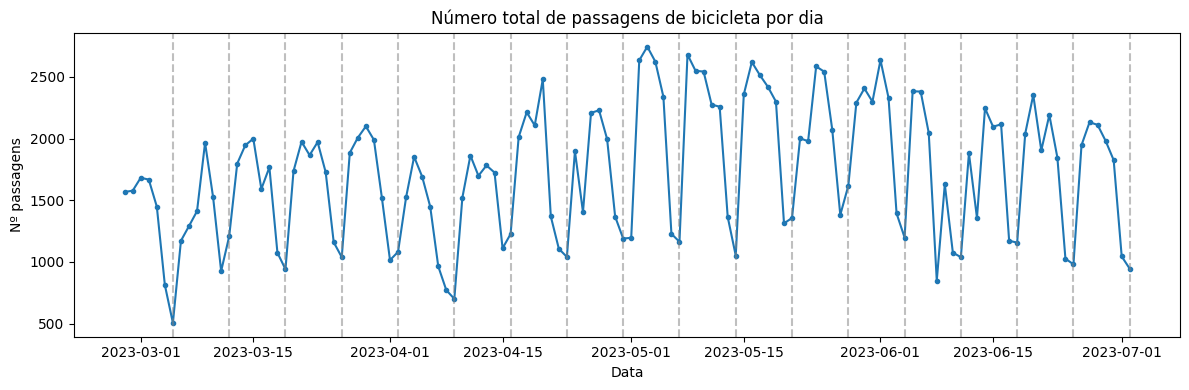

In [17]:
df = pd.read_csv('count_locationId_22.csv', parse_dates=['detected'], dtype={"contagem": np.int32}, index_col=['detected'])

pass_diarias = df.resample('D').sum()

plt.figure(figsize=(12, 4))
plt.plot(pass_diarias.index, pass_diarias['contagem'], marker='.', linestyle='-')


week_starts = df.resample('W').first().index
for start in week_starts:
    plt.axvline(x=start, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Data')
plt.ylabel('Nº passagens')
plt.title('Número total de passagens de bicicleta por dia')
plt.tight_layout()
plt.show()

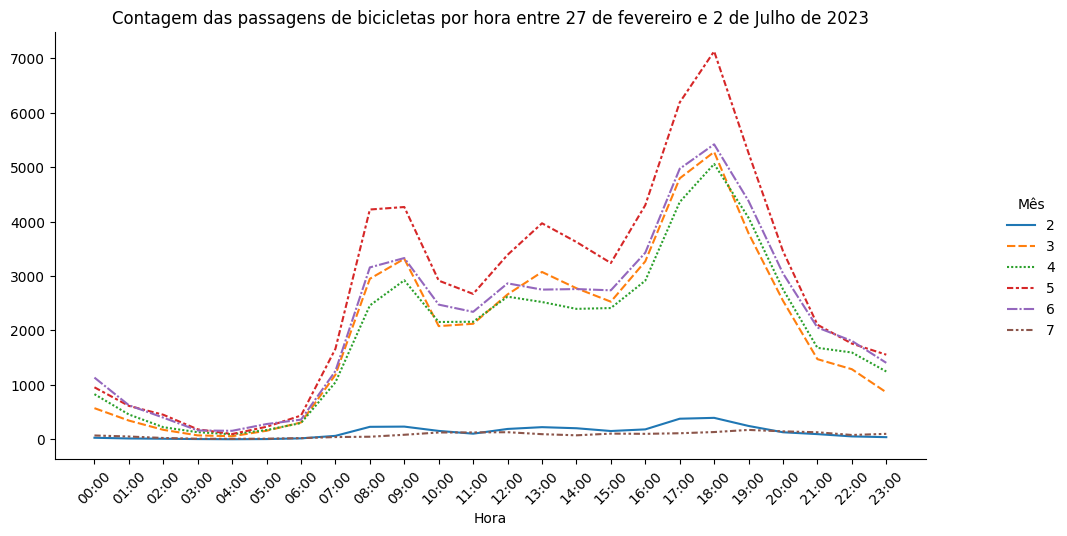

In [18]:

df = pd.read_csv('count_locationId_22.csv', parse_dates=['detected'], dtype={"contagem": int}, index_col=['detected'])
df['Data'] = df.index.strftime('%Y-%m-%d')
df['Hora'] = df.index.strftime('%H:%M')
df['Mês'] = df.index.month  # Adiciona uma coluna 'month' contendo o mês de cada entrada


df_wide = df.pivot_table(index='Hora', columns="Mês", values="contagem", aggfunc='sum')


fig1 = sns.relplot(data=df_wide, kind="line")
plt.xticks(rotation=45)
fig1.fig.set_size_inches(12, 5)


plt.title('Contagem das passagens de bicicletas por hora entre 27 de fevereiro e 2 de Julho de 2023')

plt.show()

### ``Análise``
- A análise dos gráficos anteriores permite concluir que ``existe uma sazonalidade múltipla de padrão semanal (168h) e diário (24h)``.
- No primeiro gráfico verificamos que o número de passagens de bicicleta em dias úteis é superior a número de passagens registados ao fim de semana. Geralmente os dias em que se registam mais de passagens são de terça a quinta-feira.
- No segundo gráfico verifica-se um baixo registo de passagens entre as 0h e as 6h seguido de uma tendência crescente até às 8h e um ligeiro decréscimo entre as 9h e as 11h. Entre as 11h e as 15h volta a existir um ligeiro aumento seguido de uma diminuição e a partir as 15h regista-se um acréscimo que atinge o pico às 18h, hora a partir da qual se regista um novo decréscimo mais acentuado até às 21h e que vai estabilizando até às 3h.
- No primeiro gráfico é evidente uma tendência crescente em Abril e uma tendência decrescente entre o final de Maio e o dia 2 de Julho.


> **Tarefa 12:** Façam a decomposição mais adequada da série. Apresentem-na graficamente (visualização 1). Obtenham um gráfico apenas com a parte sazonal e a componente irregular (visualização 2). Comentem o resultado.

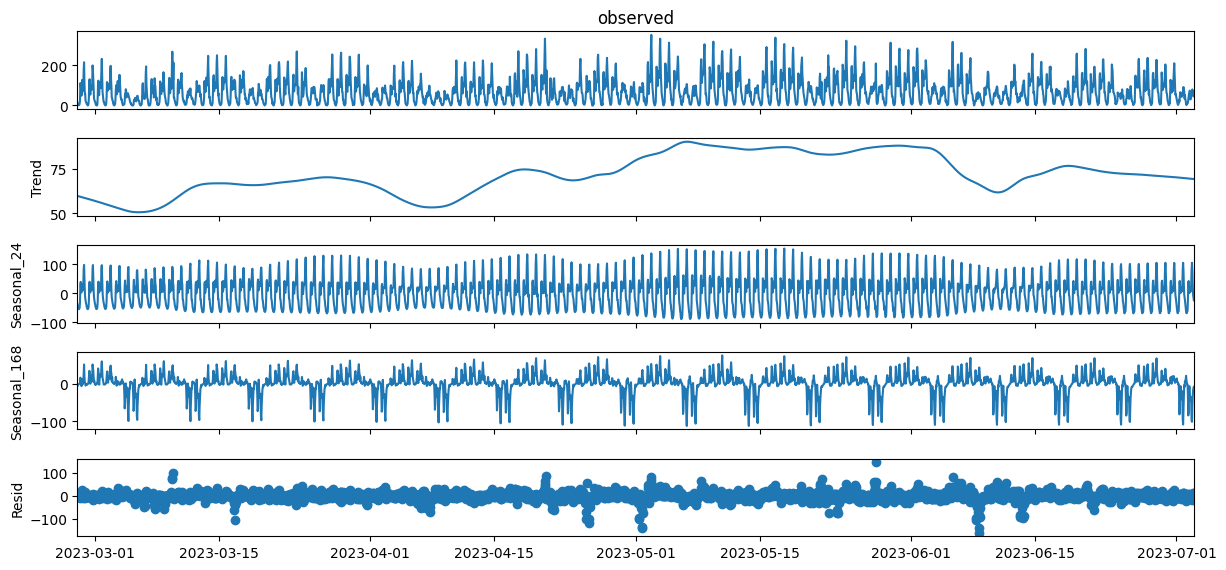

In [19]:
df = pd.read_csv('count_locationId_22.csv', parse_dates=['detected'], dtype={"contagem": int}, index_col=['detected'])

mstl = MSTL(df["contagem"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0, "inner_iter": 2, "outer_iter": 0})

res = mstl.fit()

ax = res.plot()
ax.set_size_inches((14,6));
plt.show()


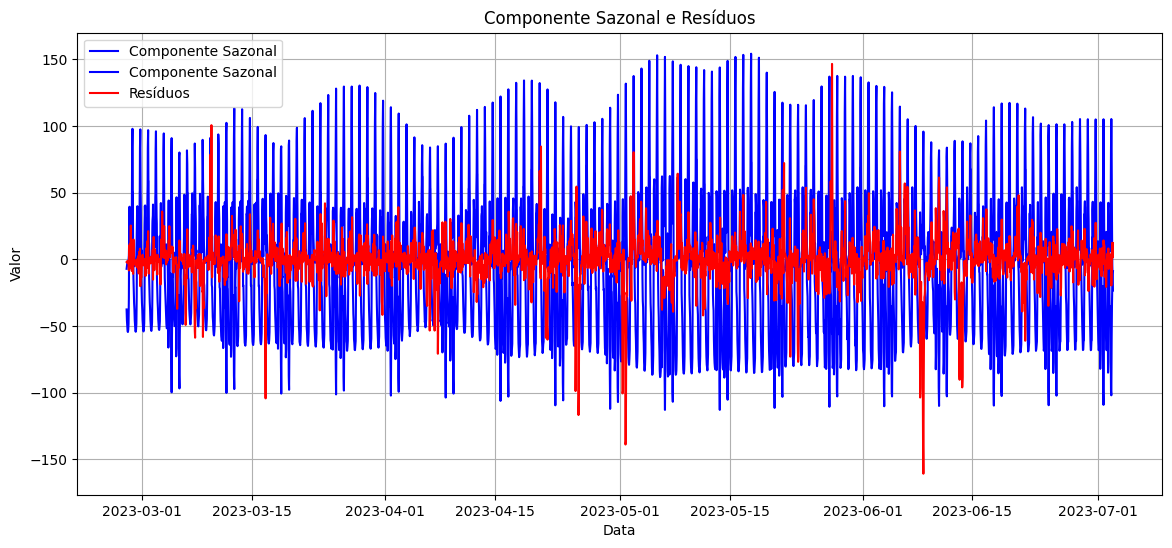

In [20]:
plt.figure(figsize=(14, 6))

plt.plot(res.seasonal.index, res.seasonal.values, label='Componente Sazonal', color='blue')

plt.plot(res.resid.index, res.resid.values, label='Resíduos', color='red')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Componente Sazonal e Resíduos')
plt.legend()
plt.grid(True)

plt.show()

### ``Análise do Resultado``
- Para a decomposição da série foi ``utilzado o método aditivo`` porque na análise dos gráficos das tarefas 9 e 11 são observadas oscilações sazonais de magnitude aproximadamente constante.
**Através da decomposição da série obtemos:**
- **``tendência``** representada por uma linha suave que indica o padrão de crescimento e declínio da série independentemente da sazonalidade. É possível observar, por exemplo um aumento do número de passagens de abril a maio e um decréscimo em junho. No caso em estudo a tendência poderá ser influênciada por fatores tais como as condições climatéricas como a precipitação e temperatura ou por fatores como os perídos de férias mais frequentes, no entanto para verificar a eventual influência de outros fatores seria necessário um estudo para identificar possíveis correlações.
- **``componente sazonal diária``** que representa o padrão verificado em intervalos de 24h identificado na tarefa 11.
- **``componente sazonal semanal``** que representa o padrão que se repete em intervalos de 168h (24x7h) e identificado anteriormente na tarefa 11.
- **``componente irregular ou resíduos``**, representa as flutuações imprevisíveis e que não podem ser explicadas pela componente sazonal e pela tendência. Esta componente é obtida através da remoção, neste caso pela subtração, das componentes sazonais e da tendência.
### ``Conclusão``
- A observação do gráfico da componente sazonal e resíduos indica que a decomposição feita pelo método aditivo foi bem sucedida porque o padrão obtido para a componente irregular é aleatório e não parece seguir o padrão das componentes sazonais. Através desta componente podemos verificar que existiram desvios muito significativos em alguns momentos que poderão ter sido influênciados por outros fatores. No dia 8 de maio de 2023 por exemplo, verificou-se um decréscimo comparativamente às mesmas horas e dias da semana e quando considerada a tendência crescente verificada nesse período.






## _8. Identificação dos outliers

> **Tarefa 13:** Com base na decomposição obtida no tarefa anterior, determinem os outliers da série, identificando esses valores e os *timestamps* correspondentes. Comentem o resultado.

In [ ]:
# Inserir aqui o código da função que permite obter outliers pelo método de Tukey.
def tukey_fences(df, column):
    """
    Given the data frame and one of its numeric columns, outputs the Tukey's fences for that column.
    inputs: df - pandas data frame; column - string
    output: two floats, the first is the lower fence and the second is the upper fence
    """
    Q1 = df.quantile(0.25).loc[column]
    Q3 = df.quantile(0.75).loc[column]
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    return lower_fence, upper_fence

def outlier_tukey(df, column):
    """
    Given the data frame and a numeric column, outputs the outlier data frame.
    inputs: df - pandas data frame; column - string
    output: pandas data frame
    """
    lower_fence, upper_fence = tukey_fences(df, column)
    df_outliers = df.query(f'{column} < @lower_fence or {column} > @upper_fence')
    return df_outliers

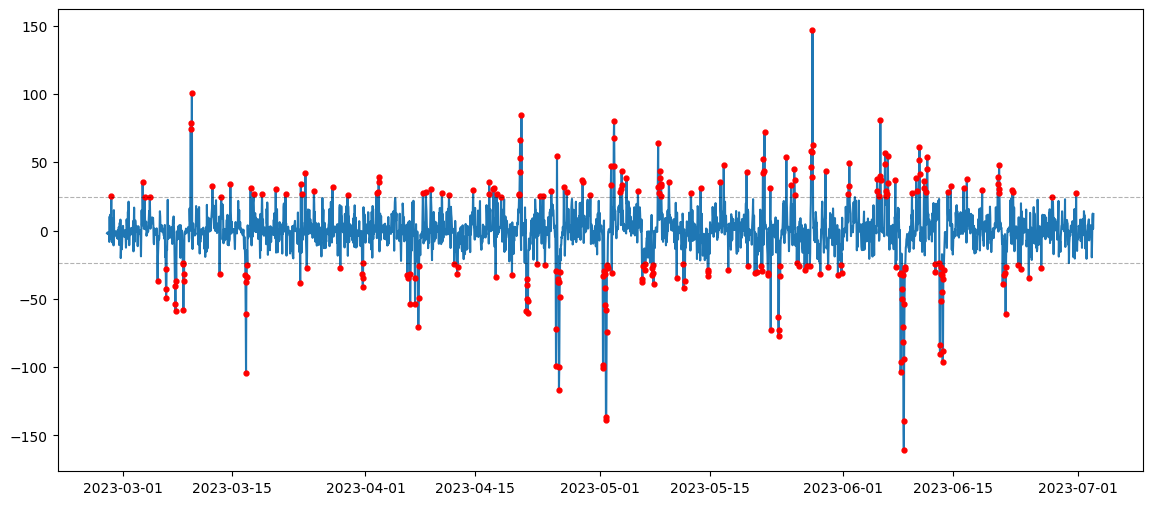

In [ ]:
# Inserir aqui todo o código para a obtenção dos outliers da tarefa 13.
df_residual = pd.DataFrame(res.resid)

df_residual.columns = ['residual']

outliers = outlier_tukey(df_residual, 'residual')

# Completar com a data frame outliers
cm = sns.color_palette("vlag", as_cmap=True)
outliers.filter(['residual']).style.background_gradient(cmap=cm).format("{:.3}")

# Criar uma data frame que junte as data frames da melhor decomposição e dos outliers
decomp_with_outliers = pd.concat([df_residual, outliers], axis=1)

# Corrigir o nome das quatro últimas colunas
decomp_with_outliers.columns = ['residual','residual_out']

l_fence, u_fence = tukey_fences(df_residual,'residual')

fig, ax = plt.subplots(1, 1, figsize=(14,6))
ax.plot(decomp_with_outliers.residual)
ax.plot(decomp_with_outliers.residual_out, linestyle='', marker='.', markersize=7, color='red')
ax.axhline(l_fence, color='black', linestyle="--", linewidth=0.8, alpha=0.3)
ax.axhline(u_fence, color='black', linestyle="--", linewidth=0.8, alpha=0.3)
plt.show()

In [ ]:
# apresentar os valores com timestamp
decomp_with_outliers.residual_out.dropna()

detected
2023-02-27 13:00:00    25.364780
2023-03-03 13:00:00    35.851921
2023-03-03 19:00:00    24.845872
2023-03-04 11:00:00    24.870244
2023-03-05 11:00:00   -37.208252
                         ...    
2023-06-23 16:00:00   -28.300658
2023-06-24 17:00:00   -34.887050
2023-06-26 07:00:00   -27.118118
2023-06-27 16:00:00    24.832278
2023-06-30 18:00:00    27.410676
Name: residual_out, Length: 291, dtype: float64